### Training a Classifier

torchvision has dataloaders for:
* ImageNet
* CIFAR10
* MNIST

using 
*torchvision.datasets* 
and 
*torch.utils.data.DataLoader*

We will do the following steps:


1. Load and normalizing the CIFAR10 training and test datasets using torchvision
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

In [23]:
from __future__ import print_function

### 1. Loading and normalizing CIFAR10

In [1]:
import torch

import torchvision

import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1]

In [2]:
# we can use transforms.Compose to make list of all tensors

In [3]:
list_of_transforms = [transforms.ToTensor(),
                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
transform = transforms.Compose(list_of_transforms)


In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                       transform=transform)

Files already downloaded and verified


In [5]:
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=4,
                                          shuffle=True,
                                         num_workers=2)

In [6]:
testset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=True,
                                       transform=transform)

Files already downloaded and verified


In [7]:
testloader = torch.utils.data.DataLoader(testset,
                                        batch_size=4,
                                        shuffle=False,
                                        num_workers=2)

In [8]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [9]:
from matplotlib import pyplot as plt

In [10]:
%matplotlib inline

In [11]:
import numpy as np

In [31]:
def imshow(img):
    img = img / 2 + 0.5 # unormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

In [13]:
# get some random training images
dataiter = iter(trainloader)
images,labels = dataiter.next()

 bird  frog truck  ship


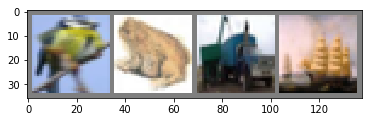

In [14]:
#show images
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 2. Define a Convolutional Neural Network

In [15]:
from torch.autograd import Variable

In [16]:
import torch.nn as nn
import torch.nn.functional as F

In [17]:
class Net(nn.Module):
    
    def __init__(self):
        # calls nn.Module function
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
      
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        #affine -> y = Wx + b
        # input is 16*5*5 vector (well its 16x5x5 image, but gets flattened?)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        # Max pooling over a (2,2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        # or you can just say 2
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # flatten
        x = x.view(-1,16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    
        

In [18]:
net = Net()

### 3. Define a Loss function and optimizer

In [19]:
import torch.optim as optim

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),
                      lr=0.001,
                      momentum=0.9)

### 4. Train the network

In [21]:
print_every = 2000
for epoch in range(2):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get inputs
        inputs, labels = data
        
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)
        
        #zero the parameter gradients in the buffers
        optimizer.zero_grad()
        
        #forward + backward + optimize (update weights)
        
        # forward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        #backward
        loss.backward()
        
        #update weights (optimize)
        optimizer.step()
        
        #print statistics
        running_loss += loss.data[0]
        
        if i % print_every == print_every -1: # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, running_loss / print_every ))
            running_loss = 0.0
print('Finished Training')
            
        

[1,  2000] loss: 2.254
[1,  4000] loss: 1.936
[1,  6000] loss: 1.699
[1,  8000] loss: 1.567
[1, 10000] loss: 1.499
[1, 12000] loss: 1.458
[2,  2000] loss: 1.366
[2,  4000] loss: 1.354
[2,  6000] loss: 1.355
[2,  8000] loss: 1.311
[2, 10000] loss: 1.312
[2, 12000] loss: 1.294
Finished Training


### 5. Test the network on the test data

##### ok let's print some images from the test set with their ground truth label

GroundTruth:    cat  ship  ship plane


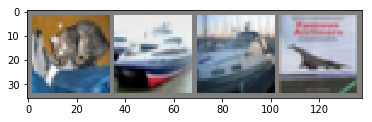

In [32]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] 
                                for j in range(4)))

##### ok now let's get our predictions on these same images

In [33]:
outputs = net(Variable(images))

In [35]:
outputs.data.shape

torch.Size([4, 10])

In [36]:
# get the column (class) index (dimension 1) of the max output value for each row (example)
column_dimension = 1 
_, predicted = torch.max(outputs.data, column_dimension)

In [37]:
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


##### let's compute da accuracy

In [42]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, column_dimension)
    total += labels.size(0)
    correct += (predicted == labels).sum()
    
print('accuracy of the network on 10000 test images: %d %%' % (100 * correct / total))

accuracy of the network on 10000 test images: 54 %


In [43]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 48 %
Accuracy of   car : 68 %
Accuracy of  bird : 25 %
Accuracy of   cat : 52 %
Accuracy of  deer : 66 %
Accuracy of   dog : 30 %
Accuracy of  frog : 61 %
Accuracy of horse : 52 %
Accuracy of  ship : 74 %
Accuracy of truck : 68 %


##### Trainin on da GPU

 dis transfers your network to da GPU. 
 Will recursively go over all modules and convert
 their parameters to CUDA tensors: 

In [45]:
net.cuda()

You also need to send the inputs and targets to the ol' GPU

In [47]:
inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())